In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

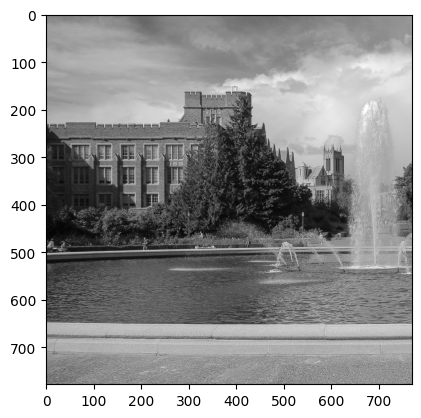

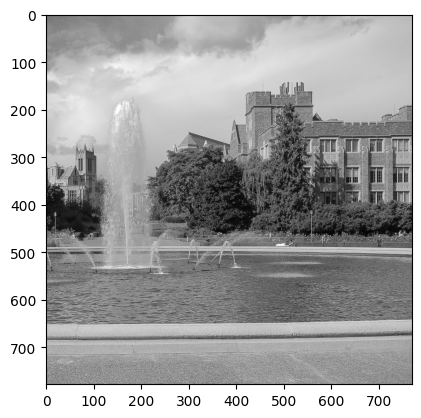

In [3]:
F1 = cv2.imread('mats/fontanna1.jpg', cv2.IMREAD_GRAYSCALE)
F2 = cv2.imread('mats/fontanna2.jpg', cv2.IMREAD_GRAYSCALE)

plt.imshow(F1, cmap='gray')
plt.show()
plt.imshow(F2, cmap='gray')
plt.show()

In [4]:
def h_from_autocorr(gray, sobel_size:int, gauss_size:int):
  # filter the image with sobel horizontal and vertical
  sobelx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=sobel_size)
  sobely = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=sobel_size)
  # calculate the gradient
  grad = np.sqrt(sobelx**2 + sobely**2)

  # filter the gradient with gaussian
  gauss = cv2.GaussianBlur(grad, (gauss_size, gauss_size), 0)

  K = 0.05

  # calculate the harris matrix
  M = np.zeros((gray.shape[0], gray.shape[1], 2, 2))
  M[..., 0, 0] = gauss * sobelx**2

  M[..., 0, 1] = gauss * sobelx * sobely
  M[..., 1, 0] = gauss * sobelx * sobely
  M[..., 1, 1] = gauss * sobely**2

  # calculate the harris response
  det = M[..., 0, 0] * M[..., 1, 1] - M[..., 0, 1] * M[..., 1, 0]

  trace = M[..., 0, 0] + M[..., 1, 1]

  h = det - K * trace**2

  #normalize the harris response to 0-1, with reversed colors

  h = (h - np.min(h)) / (np.max(h) - np.min(h))
  h = 1 - h

  return h


min: 0.0, max: 1.0


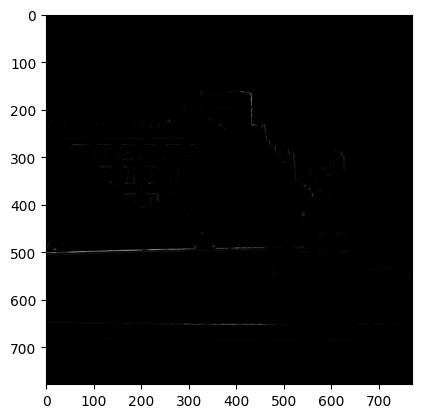

In [5]:
result = h_from_autocorr(F1, 7, 7)

plt.imshow(result, cmap='gray')

print(f'min: {np.min(result)}, max: {np.max(result)}')

C:\Users\Karolina\AppData\Local\Temp\ipykernel_8384\1019379320.py:4: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  data_max = filters.maximum_filter(image , size)


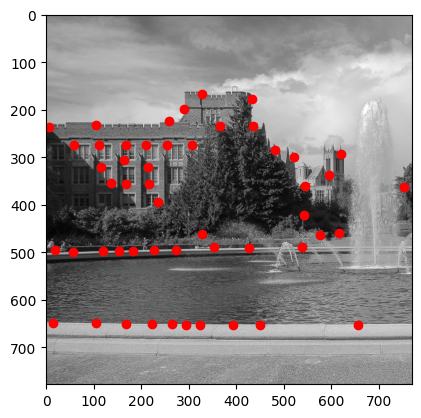

In [6]:
import scipy.ndimage.filters as filters

def find_max(image , size , threshold) : # size - maximum filter mask size
  data_max = filters.maximum_filter(image , size)
  maxima = (image == data_max)
  diff = image >threshold
  maxima[diff == 0] = 0
  return np.nonzero(maxima)

maxima = find_max(result, 50, 0.1)

plt.imshow(F1, cmap='gray')
plt.plot(maxima[1], maxima[0], 'ro')
plt.show()


In [7]:
def find_characters(image, sobel_size, gauss_size, maxima_size, threshold):
  h = h_from_autocorr(image, sobel_size, gauss_size)
  maxima = find_max(h, maxima_size, threshold)
  
  plt.imshow(image, cmap='gray')
  plt.plot(maxima[1], maxima[0], 'ro')
  plt.show()

C:\Users\Karolina\AppData\Local\Temp\ipykernel_8384\1019379320.py:4: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  data_max = filters.maximum_filter(image , size)


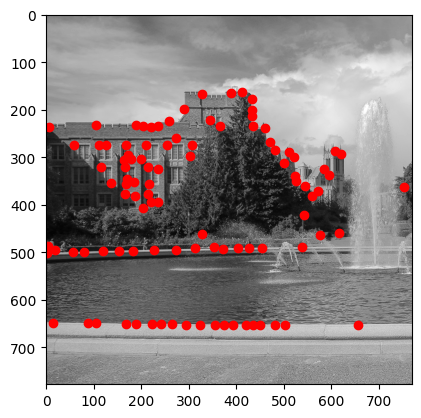

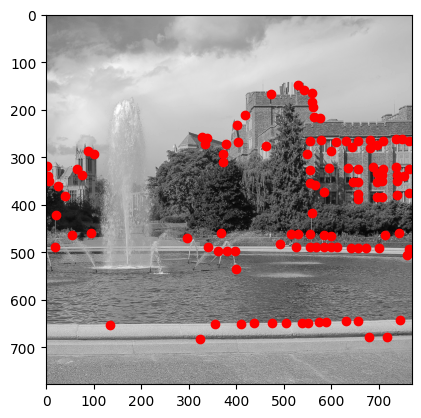

In [8]:
find_characters(F1, 7, 7, 20, 0.1)
find_characters(F2, 7, 7, 20, 0.1)

C:\Users\Karolina\AppData\Local\Temp\ipykernel_8384\1019379320.py:4: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  data_max = filters.maximum_filter(image , size)


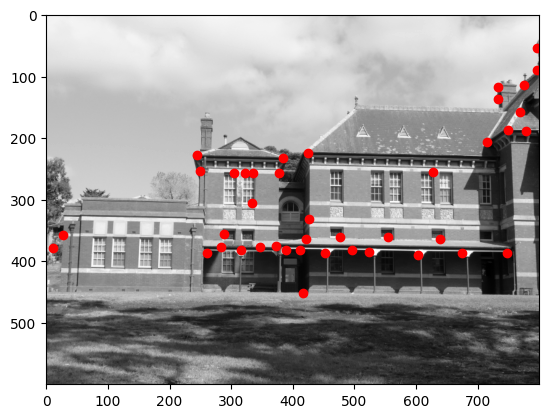

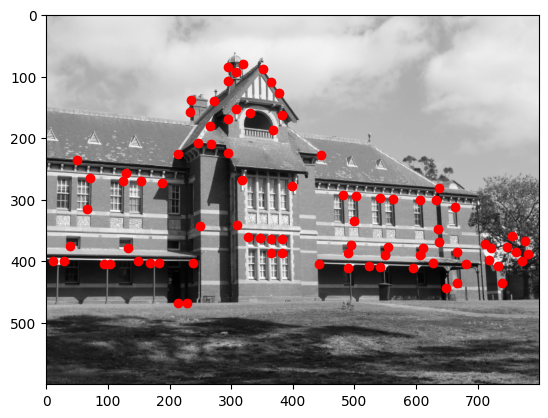

In [9]:
budynek1 = cv2.imread('mats/budynek1.jpg', cv2.IMREAD_GRAYSCALE)
budynek2 = cv2.imread('mats/budynek2.jpg', cv2.IMREAD_GRAYSCALE)

find_characters(budynek1, 7, 7, 20, 0.1)
find_characters(budynek2, 7, 7, 20, 0.1)

### Prosta deskrypcja punktów charakterystycznych

In [10]:
def desc_points(image, pts, size):
  X = image.shape[1]
  Y = image.shape[0]
  pts = list(filter(lambda pt: pt[0] >= size and pt[0]< Y-size and pt[1]>= size and pt[1] < X-size , zip(pts[0],pts[1])))
  descs = []
  for pt in pts:
    descs.append(image[pt[0]-size:pt[0]+size+1, pt[1]-size:pt[1]+size+1].flatten())
  
  result = list(zip(pts, descs))

  return result


result = h_from_autocorr(F1, 7, 7)
maxima = find_max(result, 50, 0.1)

pts = np.array(maxima)
desc = desc_points(F1, pts, 2)

C:\Users\Karolina\AppData\Local\Temp\ipykernel_8384\1019379320.py:4: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  data_max = filters.maximum_filter(image , size)


In [11]:
def match_descs(d1, d2):
    '''
    brute force comparison of two sets of descriptors to find the best match
    between both sets
    return the indexes i1 and i2 of the best match
    d1 and d2 are lists of descriptors
    descriptors are 2D arrays of values 0-255
 
    '''
    best_score = np.inf
    i1 = -1
    i2 = -1
 
    for i in range(len(d1)):
        for j in range(len(d2)):
            score = np.sum(np.abs(d1[i] - d2[j]))
            if score < best_score:
                best_score = score
                i1 = i
                i2 = j
 
    return i1, i2
 
def match_points(image1, image2, pts1, pts2, size):
    '''
    match two sets of points in two images
    image1 and image2 are the images
    pts1 and pts2 are the points
    size is the size of the descriptor
    return the indexes of the best matches
    '''
 
    descs1 = desc_points(image1, pts1, size)
    descs2 = desc_points(image2, pts2, size)
 
    matches = []
 
    for i in range(len(descs1)):
        best_match = match_descs(descs1[i][1], descs2)
        matches.append((descs1[i][0], descs2[best_match[1]][0]))
 
    return matches
 
result = h_from_autocorr(F1, 7, 7)
maxima1 = find_max(result, 50, 0.1)
result = h_from_autocorr(F2, 7, 7)
maxima2 = find_max(result, 50, 0.1)
 
matches = match_points(F1, F2, maxima1, maxima2, 2)

C:\Users\Karolina\AppData\Local\Temp\ipykernel_8384\1019379320.py:4: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  data_max = filters.maximum_filter(image , size)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.